Field Interpolation
==============

Given a set of samples of an unkown function, _estimate_ a function $f$


In [1]:
import seaborn as sns
sns.set_theme()
sns.set(style='darkgrid', context='talk', palette='Pastel1')


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

$$f(0) = -1$$
$$f(1) = 0.2$$
$$f(2) = 0.9$$
$$f(3) = 2.1$$

Estimate a line, $f(x) = kx + m$, using linear last squares

$$-1 = k*0 + m$$
$$0.2 = k*1 + m$$
$$0.9 = k*2 + m$$
$$2.1 = k*3 + m$$

Or just

$$
\begin{bmatrix}
0 & 1 \\
1 & 1 \\
2 & 1 \\
3 & 1 \\
\end{bmatrix}
\begin{bmatrix} k \\ m \end{bmatrix}
= 
\begin{bmatrix}
-1 \\ 0.2 \\ 0.9 \\ 2.1 \\
\end{bmatrix}$$
$$A\begin{bmatrix} k \\ m \end{bmatrix} = \bf{b}$$

In [3]:
import numpy as np

# sampled points
x = np.array([0, 1, 2, 3])
y = np.array([-1, 0.2, 0.9, 2.1])

A = np.vstack([x, np.ones(x.shape)]).T
k, m = np.linalg.lstsq(A, y, rcond=None)[0]

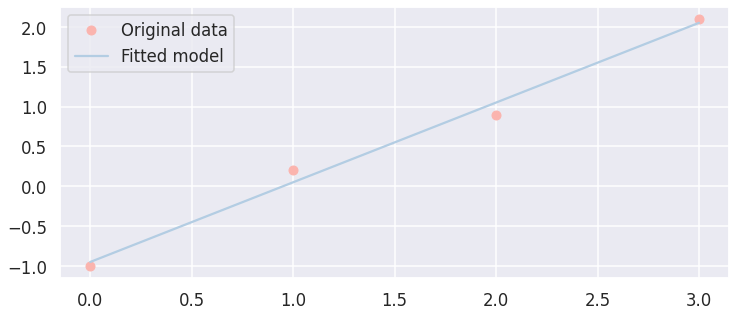

In [4]:
def plot(x0, y0, x1, y1):
    plt.plot(x0, y0, 'o', label='Original data')
    plt.plot(x1, y1, label='Fitted model')
    plt.legend()
    plt.show()

plot(x, y, x, k*x + m)

### Lattice model
Instead of using a line, lets use the _values_ at specific lattice points as the model. We use a finite grid with a high and low limit. The downside is we can only evaluate it within the bounds, whereas the line model could be evaluated everywhere.

$$
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
x_0 \\ x_1 \\ x_2 \\ x_3
\end{bmatrix}
=
\begin{bmatrix}
-1 \\ 0.2 \\ 0.9 \\ 2.1 \\
\end{bmatrix}
$$

$$A\bf{x} = \bf{b}$$



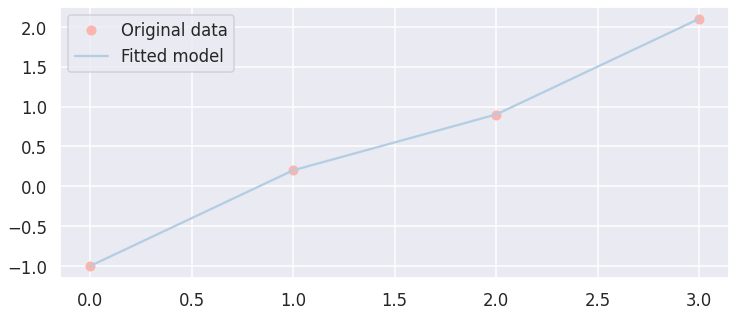

In [5]:
plot(x, y, x, y)

But what if we have more points? And that are not exactly _on_ the lattice grid?

$$f(0) = -1$$
$$f(1) = 0.2$$
$$f(2) = 0.9$$
$$f(2.2) = 1$$
$$f(3) = 2.1$$

Then we do linear interpolation ("lerp"). The closest lattice points are 2 and 3.

$$0.8 \cdot f(2) + 0.2 \cdot f(3) = 1$$

In [31]:
EPSILON = 1e-8

def value_constraints(xx, n):
    for f, i in zip(*np.modf(xx)):
        row = np.zeros(n)
        if 1 - f > EPSILON:
            row[int(i)] = 1 - f
        if f > EPSILON:
            row[int(i) + 1] = f
        yield row
    
x = np.array([0, 1, 2, 2.2, 3])
y = np.array([-1, 0.2, 0.9, 1, 2.1])

A = np.array(list(value_constraints(x, 4)))
A

array([[1. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. ],
       [0. , 0. , 1. , 0. ],
       [0. , 0. , 0.8, 0.2],
       [0. , 0. , 0. , 1. ]])

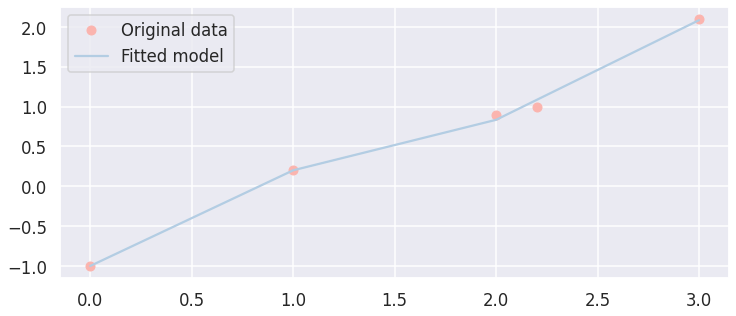

In [7]:
xg = np.linalg.lstsq(A, y, rcond=None)[0]
plot(x, y, np.arange(len(xg)), xg)

## Smoothess constraints
We can also coerce the grid model to be more smooth by $f''(x) = 0$. If we aproximate $f''$ by the finite difference $f''(x) = f(⌊x⌋ + 1) - f(⌊x⌋)$ (and likewise for $f''$) we can formulate it like so

$$f(n + 1) - f(n) = f(n + 2) - f(n)$$

For our 4-element grid we get
$$f(1) - f(0) = f(2) - f(1)$$
$$f(2) - f(1) = f(3) - f(2)$$

Or in matrix form

$$
\begin{bmatrix}
1 & -2 & 1 & 0 \\
0 & 1 & -2 & 1 \\
\end{bmatrix}
\begin{bmatrix}
x_0 \\ x_1 \\ x_2 \\ x_3
\end{bmatrix}
=
\begin{bmatrix}
0 \\ 0 \\
\end{bmatrix}
$$

In [8]:
def smoothness_constraints(n):
    for i in range(n - 2):
        row = np.zeros(n)
        row[i + 0] = 1
        row[i + 1] = -2
        row[i + 2] = 1
        yield row

A = np.array(list(value_constraints(x, 4)) + list(smoothness_constraints(4)))
A

array([[ 1. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ],
       [ 0. ,  0. ,  0.8,  0.2],
       [ 0. ,  0. ,  0. ,  1. ],
       [ 1. , -2. ,  1. ,  0. ],
       [ 0. ,  1. , -2. ,  1. ]])

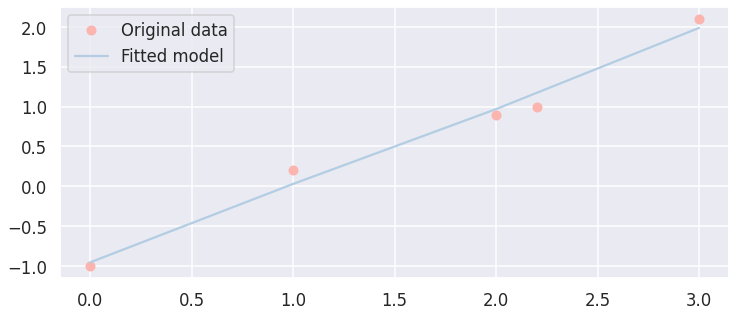

In [9]:
xg = np.linalg.lstsq(A, np.hstack([y, np.zeros(4 - 2)]), rcond=None)[0]
plot(x, y, np.arange(len(xg)), xg)

## Gradient constraints
We can also add gradient constraints if these are known. Intead of linear interpolation, just nearest neighgbor can be used. Let's say we know $f'(1.3) = 2$, we can add it as just $f(2) - f(1) = 2$


Or in matrix form

$$
\begin{bmatrix}
0 & -1 & 1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
x_0 \\ x_1 \\ x_2 \\ x_3
\end{bmatrix}
=
\begin{bmatrix}
2 \\
\end{bmatrix}
$$

## Weights
We can easily weight the different constraints by just multiplying each row by a weight.

## From another dimension
This is easy to extend with more dimenensions. For example in 2D $\nabla f(2.1, 5.8) = \begin{bmatrix} -1 & 3 \end{bmatrix}^T$ just becomes

$$f(3, 6) - f(2, 6) = -1$$
$$f(2, 6) - f(2, 5) =  3$$

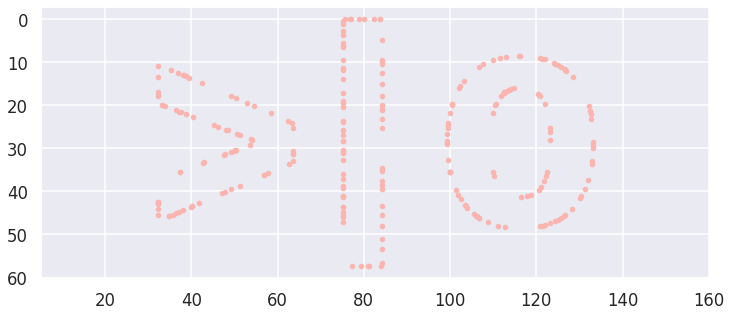

In [233]:
from typing import List

def from_complex(ca: List[complex]) -> np.ndarray:
    """convert to 2d cordinates from complex"""
    return np.vstack([ca.real, ca.imag]).T

from mini_svg.load import load_svg
shape = load_svg('volumental.svg')

np.random.seed(17)
ts = np.random.random(256)
sampled_points = from_complex(np.array([shape.point(t) for t in ts]))

plt.plot(sampled_points[:, 0], sampled_points[:, 1], '.', label='volumental.svg')
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.axis('equal')
plt.show()

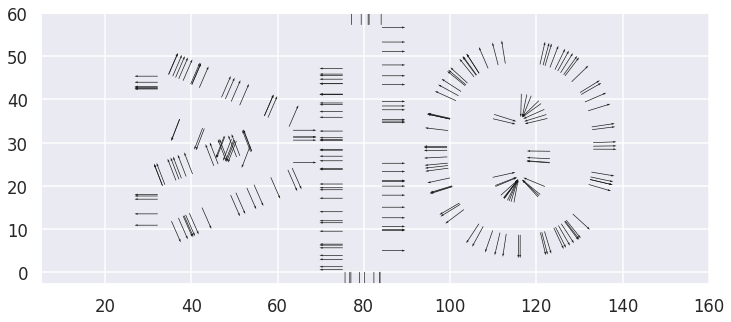

In [225]:
def normalize(a, axis=-1, order=2):
    """Normalizes array to have length 1 along specificed axis."""
    norms = np.linalg.norm(a, order, axis)
    return a / np.expand_dims(norms, axis)

sampled_normals = normalize(from_complex(np.array([shape.tangent(t) for t in ts]) * -1j))

plt.quiver(
    sampled_points[:, 0], sampled_points[:, 1],
    sampled_normals[:, 0], sampled_normals[:, 1],
    width=0.001)
plt.axis('equal')
plt.show()

In [234]:
resolution = (14, 24)

def fit_to(a, resolution, padding_fraction=0):
    r = np.flip(np.array(resolution)) - np.array([1, 1])
    top_left = np.min(a, axis=0)
    bottom_right = np.max(a, axis=0)
    size = bottom_right - top_left
    scale = np.min(r / size)
    normalized = scale * (a - top_left)
    padding = r * padding_fraction
    return (normalized + 0.5 * padding) * (1 - padding_fraction)

sampled_points = fit_to(sampled_points, resolution, 0.1)

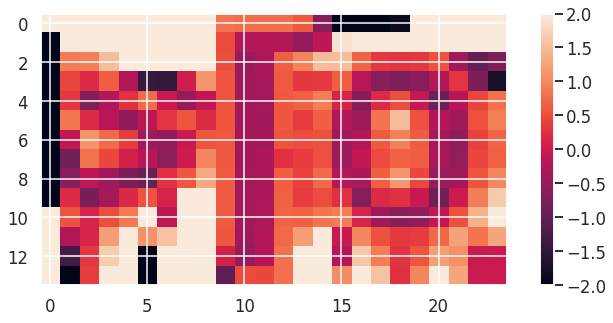

In [257]:
def index(x: int, y: int, resolution):
    """Returns the index into the grid vector"""
    _, w = resolution
    return int(x) + int(y) * w

def value_constraints_2d(points, values, resolution):
    """"binlinear interpolation"""
    rows = []
    n = np.prod(np.array(resolution))
    for (fx, fy), (ix, iy) in zip(*np.modf(points)):
        row = np.zeros(n)
        row[index(ix, iy, resolution)] = (1 - fx) * (1 - fy)
        row[index(ix + 1, iy, resolution)] = fx * (1 - fy)
        row[index(ix, iy + 1, resolution)] = (1 - fx) * fy
        row[index(ix + 1, iy + 1, resolution)] = fx * fy
        rows.append(row)
    return np.vstack(rows), values

def gradient_constraints_2d(points, normals, resolution):
    rows = []
    values = []
    n = np.prod(np.array(resolution))
    #∇f(x, y) = (nx, ny)
    # nearest neighbor
    #f(⌊⌊x⌋ + 1, ⌊y⌋ + 1) - f(⌊x⌋, ⌊y⌋ + 1) = nx
    #f(⌊⌊x⌋, ⌊y⌋ + 1) - f(⌊x⌋, ⌊y⌋) = ny
    for (fx, fy), (ix, iy), (nx, ny) in zip(*np.modf(points), normals): 
        del fx, fy  # ignore fraction part
        row = np.zeros(n)
        row[index(ix + 1, iy + 1, resolution)] = 1
        row[index(ix, iy + 1, resolution)] = -1
        rows.append(row)
        values.append(nx)
        
        row = np.zeros(n)
        row[index(ix, iy + 1, resolution)] = 1
        row[index(ix, iy, resolution)] = -1
        rows.append(row)
        values.append(ny)
        
    return np.array(rows), np.array(values)

def smoothness_constraints_2d(resolution):
    rows = []
    values = []
    n = np.prod(np.array(resolution))
    h, w = resolution
    for iy, ix in np.ndindex(h - 2, w - 2):
        row = np.zeros(n)
        row[index(ix + 0, iy, resolution)] = 1
        row[index(ix + 1, iy, resolution)] = -2
        row[index(ix + 2, iy, resolution)] = 1
        rows.append(row)
        values.append(0)
        
        row[index(ix, iy + 0, resolution)] = 1
        row[index(ix, iy + 1, resolution)] = -2
        row[index(ix, iy + 2, resolution)] = 1
        rows.append(row)
        values.append(0)
        
    return np.array(rows), np.array(values)

def field_interpolation(resolution, points, normals):
    rows0, values0 = value_constraints_2d(points, np.zeros(len(points)), resolution)
    rows1, values1 = gradient_constraints_2d(points, normals, resolution)
    rows2, values2 = smoothness_constraints_2d(resolution)
    A = np.vstack([rows0, 10*rows1, rows2])
    b = np.concatenate([values0, 10*values1, values2])
    sdf = np.linalg.lstsq(A, b, rcond=None)[0]
    return sdf.reshape(resolution)


sdf = field_interpolation(resolution, sampled_points, sampled_normals)
tsdf = np.clip(sdf, -2, 2)
plt.imshow(tsdf)
plt.colorbar()
plt.show()


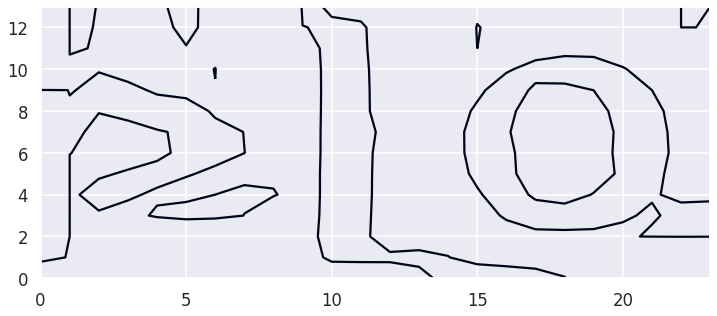

In [258]:
plt.contour(sdf, levels=[0])